<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/stand_alone_self_sttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# free sample
!wget -q https://file-examples.com/wp-content/uploads/2017/10/file_example_JPG_100kB.jpg -O sample.jpg
!ls

sample_data  sample.jpg


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid

In [0]:
print(torch.__version__)

1.5.0+cu101


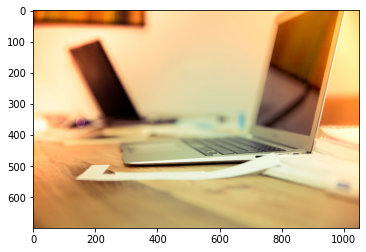

In [0]:
img = Image.open('sample.jpg')
plt.imshow(img)

In [0]:
# config
in_channels = 3
in_height   = 64
in_width    = 64

In [0]:
transform_sample = transforms.Compose([
    transforms.Resize((in_height, in_width)),
    transforms.ToTensor()
])

sample = transform_sample(img)
sample.unsqueeze_(0)
sample.size()

torch.Size([1, 3, 64, 64])

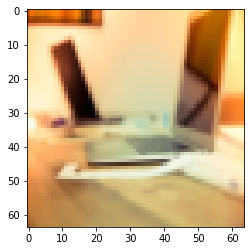

In [0]:
def imshow_tensor(tensor):
    plt.imshow(transforms.ToPILImage()(tensor.squeeze(0)))
    plt.show()


imshow_tensor(sample)

## Sample Patch-Wise

In [0]:
sample_unfold = sample.unfold(2, 7, 1).unfold(3, 7, 1)
sample_unfold.size()

torch.Size([1, 3, 58, 58, 7, 7])

In [0]:
def imshow_patch(sample, h_start=0, w_start=0, nh=5, nw=5):
    sample_batches = sample[:, :, h_start:h_start+nh, w_start:w_start+nw, :, :]
    
    fig, axes = plt.subplots(nh, nw, figsize=(3*nh, 3*nw), 
                             tight_layout=True,
                             subplot_kw=dict(xticks=[], yticks=[]))
    for nrow in range(nh):
        for ncol in range(nw):
            sample_batch = sample_batches[:, :, nrow, ncol, :, :]
            axes[nrow, ncol].imshow(transforms.ToPILImage()(sample_batch.squeeze(0)))

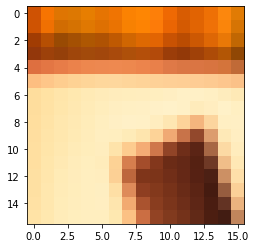

In [0]:
imshow_tensor(sample[:, :, 0:16, 0:16])

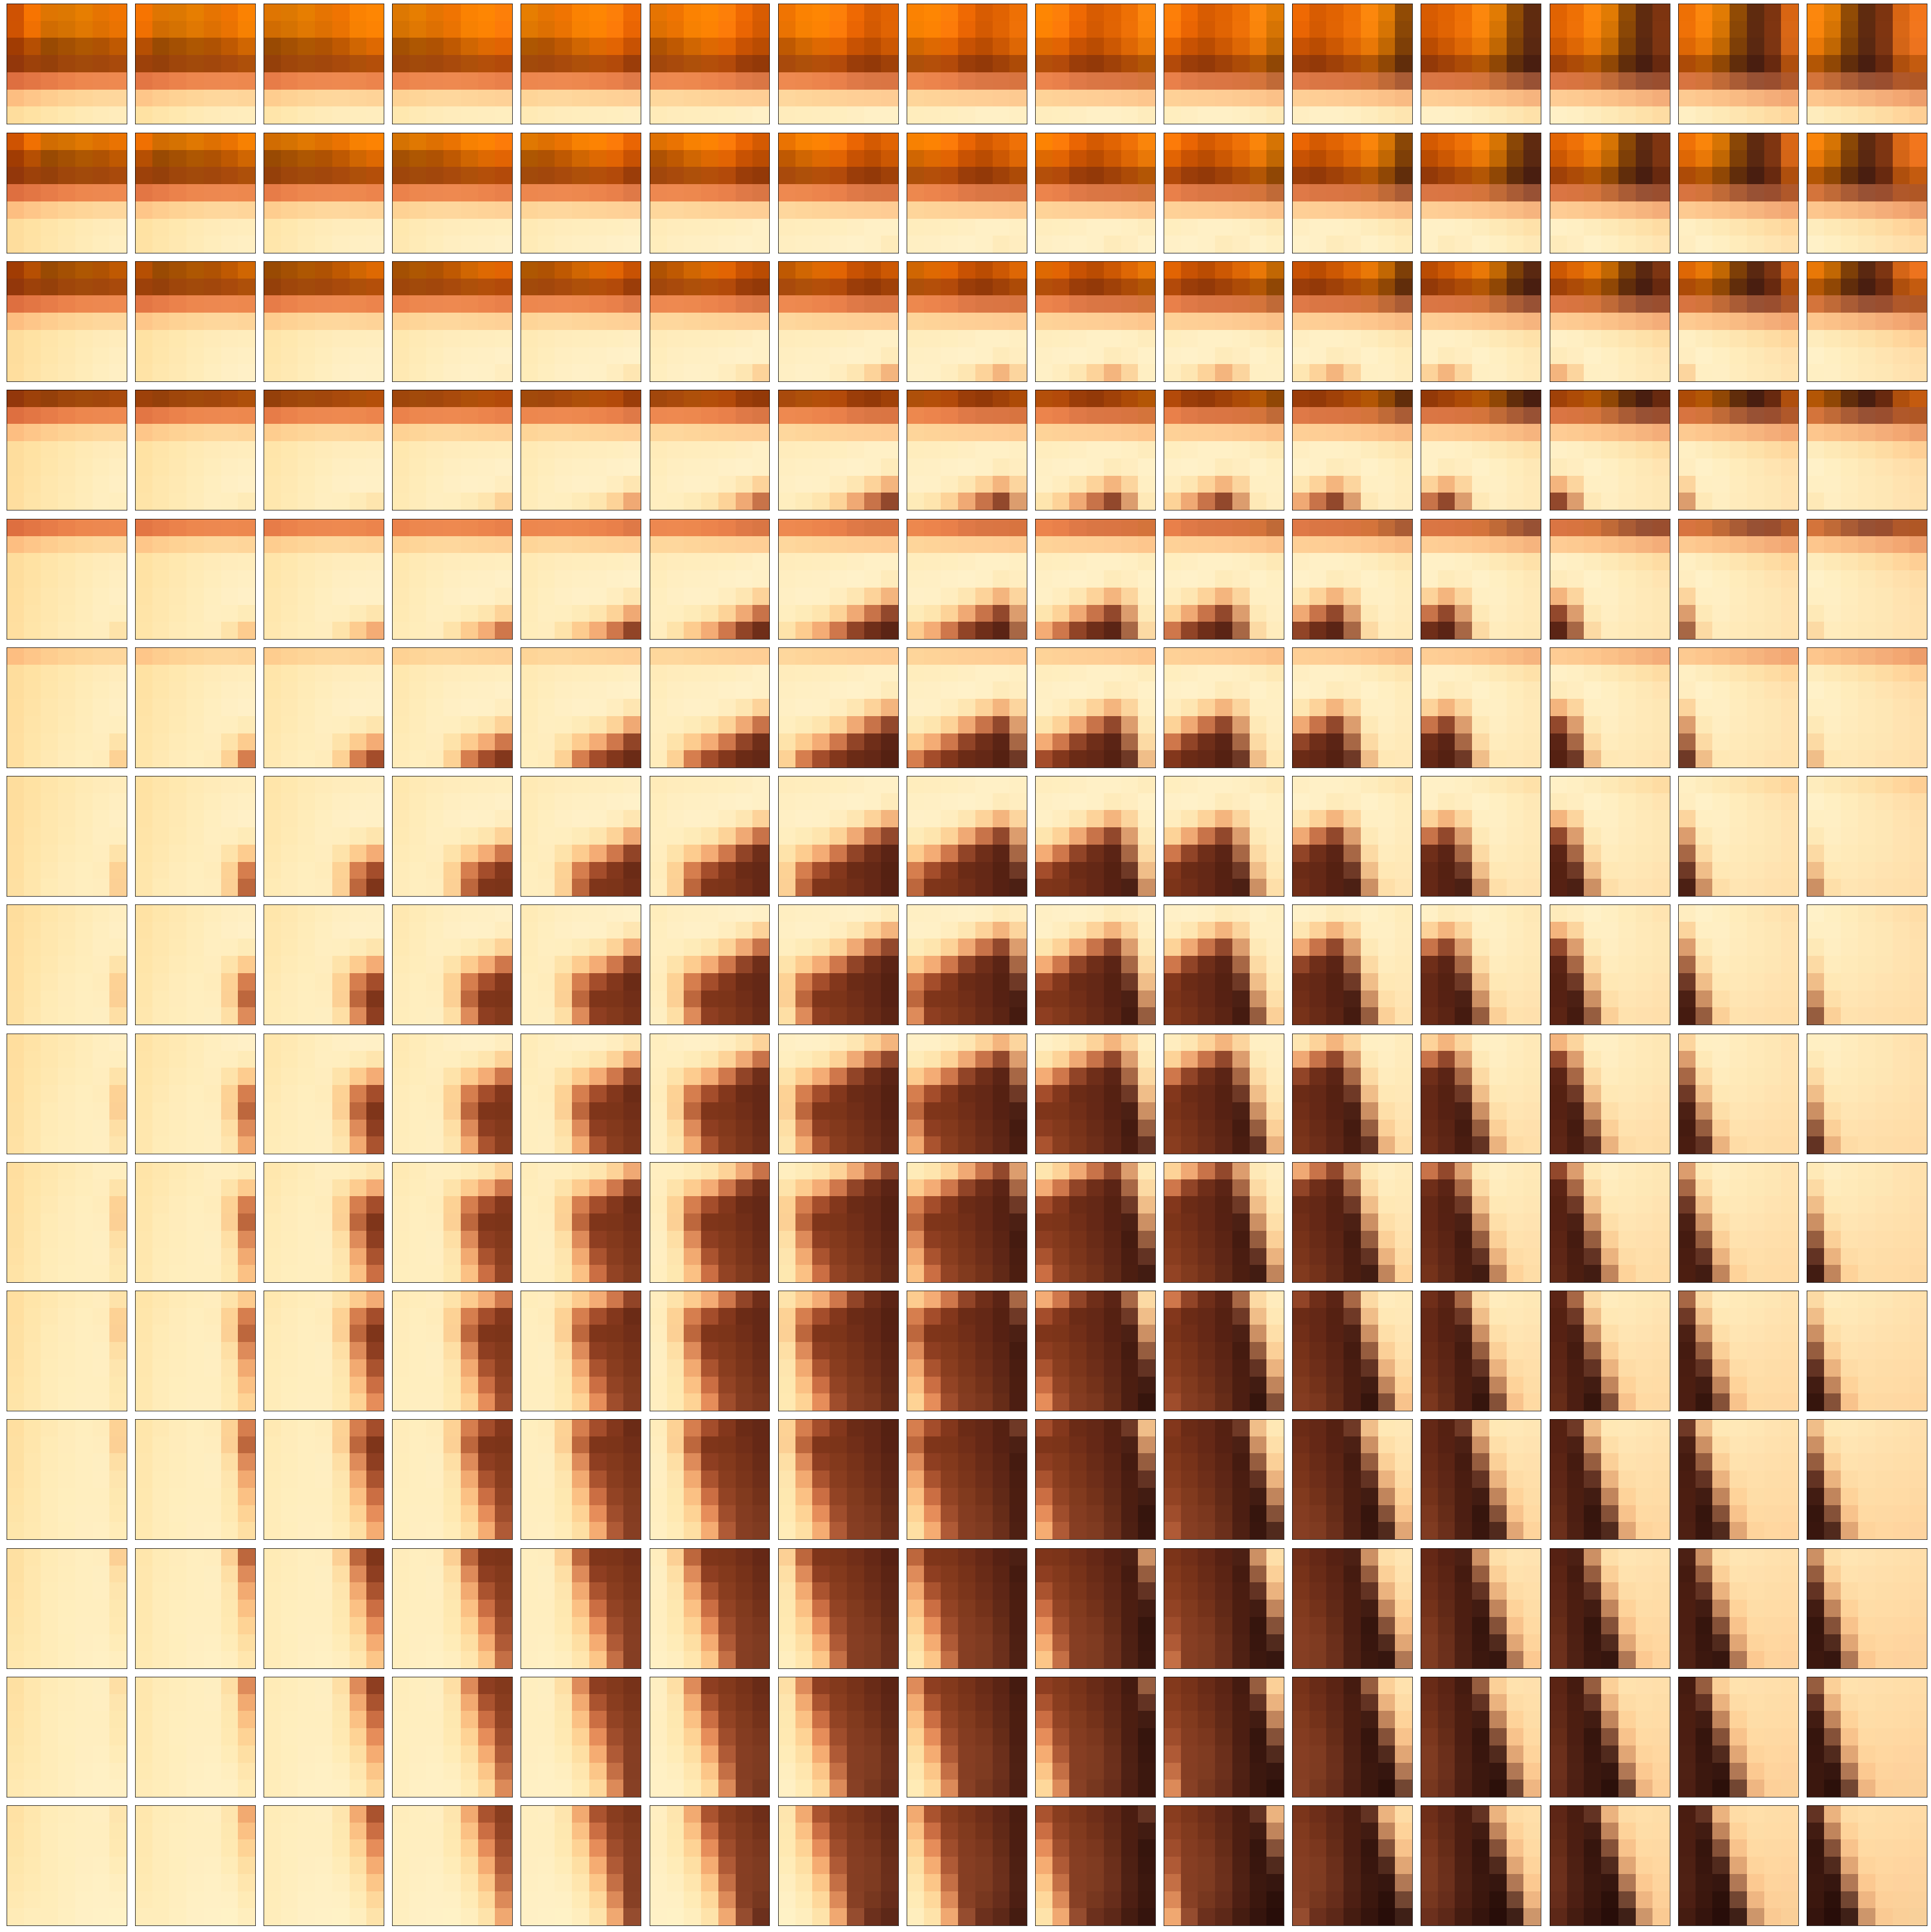

In [0]:
imshow_patch(sample_unfold, 0, 0, 15, 15)

When self-attention is applied to the displayed image, only one patch image per pixel is used as input.

## sample Softmax

In [0]:
test = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
test

tensor([[1., 2.],
        [3., 4.]])

In [0]:
F.softmax(test, dim=-1)

tensor([[0.2689, 0.7311],
        [0.2689, 0.7311]])

In [0]:
F.softmax(test, dim=0)

tensor([[0.1192, 0.1192],
        [0.8808, 0.8808]])

In [0]:
F.softmax(test, dim=1)

tensor([[0.2689, 0.7311],
        [0.2689, 0.7311]])

## Self-Attention

In [0]:
batch, channels, height, width = sample.size()

print(batch, channels, height, width)

1 3 64 64


In [0]:
# config
out_channels = 128  # channel size is as same as the input channel size
kernel_size  = 7
stride       = 1
padding      = 3
groups       = 8
bias         = False

assert out_channels % groups == 0, "out_channels should be divided by groups"

$$y_{i j}=\sum_{a, b \in N_{k}(i, j)} \operatorname{softmax}_{a b}\left(q_{i j}^{T} k_{a b}\right) v_{a b}$$

$$y_{i j}=\sum_{a, b \in \mathcal{N}_{k}(i, j)} \operatorname{softmax}_{a b}\left(q_{i j}^{T} k_{a b}+q_{i j}^{T} r_{a-i, b-j}\right) v_{a b}$$

Attention operations can be done by conv2d with kernel_size=1 because this paraemter means the simple vector at the spacial position (i, j) along all channels

In [0]:
key_conv   = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

In [0]:
key_conv.weight.data.size()

torch.Size([128, 3, 1, 1])

In [0]:
# add padding to both key and value so that the dimensionality of tensor 
# after createing patches should be same as one of non padded query image
padded_sample = F.pad(sample, [padding, padding, padding, padding])

print(sample.size())
print(padding)
print(padded_sample.size())

torch.Size([1, 3, 64, 64])
3
torch.Size([1, 3, 70, 70])


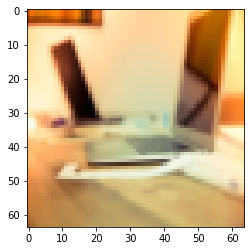

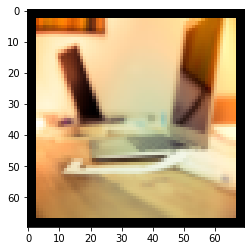

In [0]:
imshow_tensor(sample)
imshow_tensor(padded_sample)

In [0]:
q_out = query_conv(sample)
k_out = key_conv(padded_sample)
v_out = value_conv(padded_sample)

print(q_out.size())
print(k_out.size())
print(v_out.size())

torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 70, 70])
torch.Size([1, 128, 70, 70])


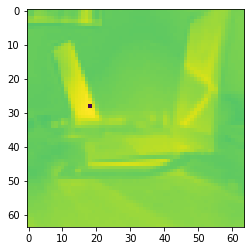

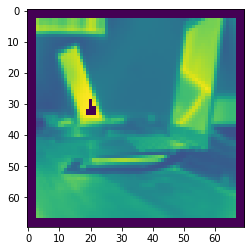

In [0]:
# conv2d 1x1
imshow_tensor(q_out[:, 0, :, :])
imshow_tensor(k_out[:, 0, :, :])

In [0]:
k_out_unfold = k_out.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
v_out_unfold = v_out.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)

print(k_out_unfold.size())
print(v_out_unfold.size())

torch.Size([1, 128, 64, 64, 7, 7])
torch.Size([1, 128, 64, 64, 7, 7])


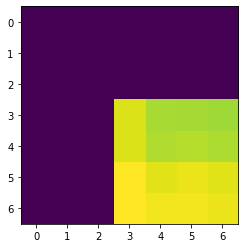

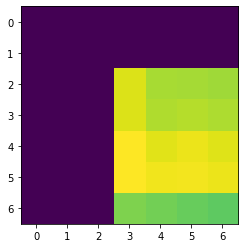

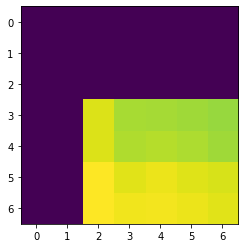

In [0]:
imshow_tensor(k_out_unfold[:, 0, 0, 0, ...])
imshow_tensor(k_out_unfold[:, 0, 1, 0, ...])
imshow_tensor(k_out_unfold[:, 0, 0, 1, ...])

In [0]:
# These parameters can be applied for each patch (7x7)
rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

In [0]:
torch.arange(7) - 3

tensor([-3, -2, -1,  0,  1,  2,  3])

In [0]:
128 // 4

32

In [0]:
print(rel_h.size())
print(rel_w.size())

torch.Size([64, 1, 1, 7, 1])
torch.Size([64, 1, 1, 1, 7])


In [0]:
print(rel_h[0, 0, 0, :, 0].data)
print(rel_w[0, 0, 0, 0, :].data)

tensor([-1.0663, -0.4426,  1.1631, -0.7400,  0.0330, -0.5483,  0.5755])
tensor([ 1.1203, -0.6315,  0.2604,  1.9676, -0.3398, -0.9524,  0.1716])


In [0]:
k_out_unfold_h, k_out_unfold_w = k_out_unfold.split(out_channels//2, dim=1)

print(k_out_unfold_h.size())

torch.Size([1, 64, 64, 64, 7, 7])


In [0]:
k_out_cat = torch.cat((k_out_unfold_h + rel_h, k_out_unfold_w + rel_w), dim=1)

print(k_out_cat.size())

torch.Size([1, 128, 64, 64, 7, 7])


In [0]:
# To reposition a contiguous region, use the contiguous method
k_out_viewed = k_out_cat.contiguous().view(batch, groups, out_channels // groups, 
                                           height, width, -1)

print(k_out_cat.size())
print(k_out_viewed.size())

torch.Size([1, 128, 64, 64, 7, 7])
torch.Size([1, 8, 16, 64, 64, 49])


In [0]:
# To reposition a contiguous region, use the contiguous method
v_out_viewed = v_out_unfold.contiguous().view(batch, groups, out_channels // groups, 
                                              height, width, -1)

print(v_out_unfold.size())
print(v_out_viewed.size())

torch.Size([1, 128, 64, 64, 7, 7])
torch.Size([1, 8, 16, 64, 64, 49])


In [0]:
q_out_viewed = q_out.view(batch, groups, out_channels // groups, height, width, 1)

print(q_out.size())
print(q_out_viewed.size())

torch.Size([1, 128, 64, 64])
torch.Size([1, 8, 16, 64, 64, 1])


In [0]:
out = q_out_viewed * k_out_viewed
out = F.softmax(out, dim=-1)

print(out.size())

torch.Size([1, 8, 16, 64, 64, 49])


In [0]:
out_ein = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out_viewed).view(batch, -1, height, width)

print(out_ein.size())

torch.Size([1, 128, 64, 64])


In [0]:
print(sample.size())

torch.Size([1, 3, 64, 64])
